# Part B1

In [1]:
import torch
import math
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz
from typing import overload
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\caspe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@overload
def f(x: float) -> float:
    ...
@overload
def f(x: torch.Tensor) -> torch.Tensor:
    ...
def f(x: float | torch.Tensor) -> float | torch.Tensor:
    """ Given function from exercise B1"""
    if isinstance(x, float):
        return math.sin(20 * x) + 2 * math.cos(14 * x) - 2 * math.sin(6 * x)
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)

In [3]:
# Setup
x = torch.Tensor([-1, -0.5, 0, 0.5, 1])
y = f(x)
N = 500
GP_noise = torch.tensor(1e-4)
sigma_l = dist.LogNormal(torch.tensor(-1, dtype=float), torch.tensor(1, dtype=float))
sigma_v = dist.LogNormal(torch.tensor(0, dtype=float), torch.tensor(2, dtype=float))

In [4]:
# Setup RBF
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(sigma_v)
kernel.lengthscale = pyro.nn.PyroSample(sigma_l)
gpr = gp.models.GPRegression(x, y, kernel, noise=GP_noise)

In [5]:
# Sample using nuts
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=N, warmup_steps=200, num_chains=5)
mcmc.run()

Warmup [1]:   0%|          | 0/700 [00:00, ?it/s]





Warmup [1]:   1%|▏         | 9/700 [00:03,  4.01it/s, step size=5.21e-02, acc. prob=0.761]









Warmup [1]:   2%|▏         | 12/700 [00:03,  4.63it/s, step size=1.48e-01, acc. prob=0.799]


Warmup [1]:   2%|▏         | 14/700 [00:04,  5.59it/s, step size=5.00e-01, acc. prob=0.827]











Warmup [1]:   3%|▎         | 18/700 [00:04,  7.30it/s, step size=1.39e-01, acc. prob=0.798]


Warmup [1]:   3%|▎         | 20/700 [00:04,  8.14it/s, step size=4.34e-01, acc. prob=0.817]

Warmup [1]:   3%|▎         | 24/700 [00:04, 11.94it/s, step size=2.03e-01, acc. prob=0.804]




Warmup [1]:   4%|▍         | 27/700 [00:04, 14.03it/s, step size=3.72e-02, acc. prob=0.781]











Warmup [1]:   4%|▍         | 30/700 [00:05, 11.46it/s, step size=1.97e-01, acc. prob=0.803]


Warmup [1]:   5%|▌         | 35/700 [00:05, 16.14it/s, step size=3.91e-01, acc. prob=0.810]

Warmup [1]:   5%|▌         | 38/700 [00:05, 18.29it/s, step size=1.39e-01, 

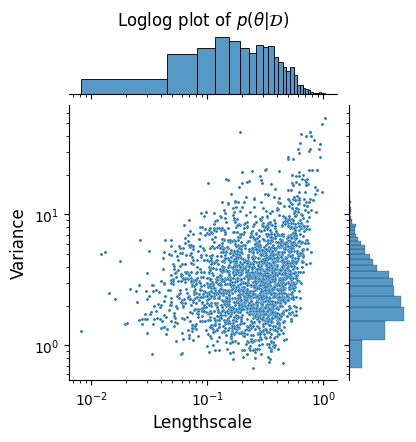

In [6]:
samples = mcmc.get_samples()
g = sns.jointplot(x=samples['kernel.lengthscale'], y=samples['kernel.variance'], height=4, ratio=4, s=5)
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
g.ax_joint.set_xlabel("Lengthscale", fontsize=12)
g.ax_joint.set_ylabel("Variance", fontsize=12)
g.ax_marg_x.set_title("Loglog plot of $p(\\theta|\mathcal{D})$", fontsize=12)
plt.show()

In [7]:
az_data = arviz.from_pyro(posterior=mcmc)
summary = arviz.summary(az_data)

summary

c:\Users\caspe\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.lengthscale,0.300,0.176,0.026,0.593,0.007,0.005,531.0,560.0,1.01
kernel.variance,4.437,4.569,0.784,10.376,0.189,0.133,861.0,798.0,1.01


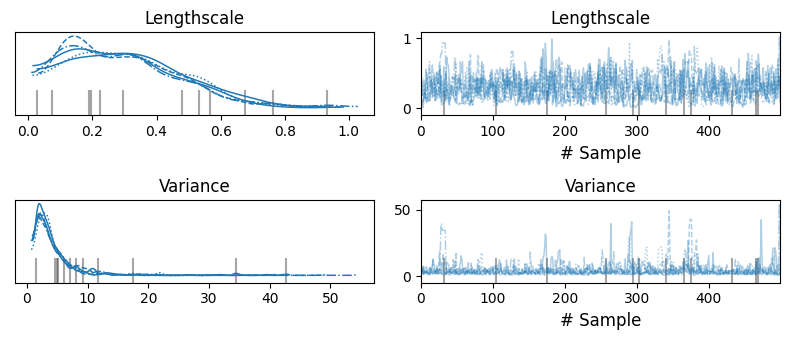

In [8]:
ax = arviz.plot_trace(az_data, figsize=(16/2, 7/2))
ax[0][0].set_title("Lengthscale", fontsize=12)
ax[0][1].set_title("Lengthscale", fontsize=12)
ax[0][1].set_xlabel("# Sample", fontsize=12)
ax[1][0].set_title("Variance", fontsize=12)
ax[1][1].set_title("Variance", fontsize=12)
ax[1][1].set_xlabel("# Sample", fontsize=12)
fig = ax[0][0].get_figure()
fig.tight_layout()
plt.show()

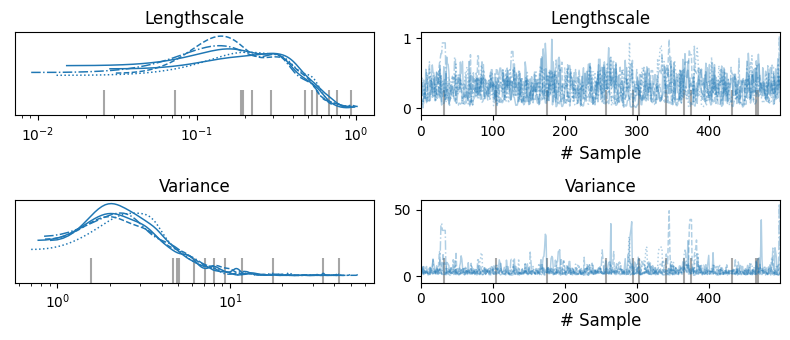

In [9]:
ax = arviz.plot_trace(az_data, figsize=(16/2, 7/2))
ax[0][0].set_xscale('log')
ax[1][0].set_xscale('log')
ax[0][0].set_title("Lengthscale", fontsize=12)
ax[0][1].set_title("Lengthscale", fontsize=12)
ax[0][1].set_xlabel("# Sample", fontsize=12)
ax[1][0].set_title("Variance", fontsize=12)
ax[1][1].set_title("Variance", fontsize=12)
ax[1][1].set_xlabel("# Sample", fontsize=12)
fig = ax[0][0].get_figure()
fig.tight_layout()
plt.show()

In [10]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(x.numpy(), y.numpy(), "kx", label="Observed data", zorder=5)
    if plot_predictions:
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), f(Xtest).numpy(), "g--", lw=2, label="f(x)", zorder=4)  # plot f(x)
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2, label="m(x)", zorder=3)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
            label="m(x)$\pm$2SE",
            zorder=2
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-1, 1, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_xlim(-1, 1)

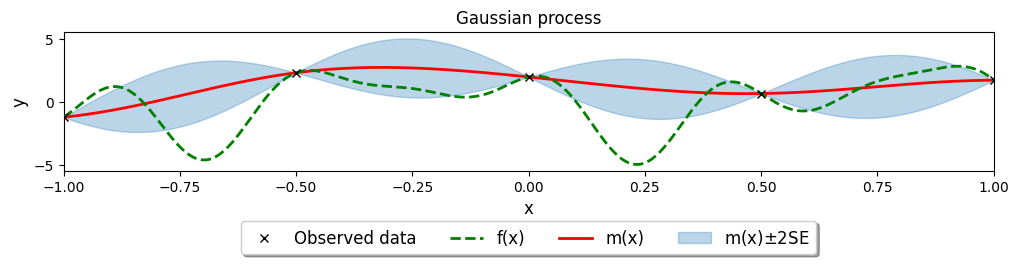

In [11]:
fig, ax = plt.subplots(figsize=(12/1, 6/2))
plot(model=gpr, plot_observed_data=True, plot_predictions=True, ax=ax)
ax.set_title("Gaussian process")
box = ax.get_position()
percent_shrink = 0.6
ax.set_position([box.x0, box.y0 + box.height * percent_shrink, box.width, box.height * percent_shrink])

# Put a legend below current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -percent_shrink/2), fancybox=True, shadow=True, ncol=5, prop={'size': 12})
plt.show()

# B.2 Bayesian Optimization

In [12]:
# Sample a GP parameters (variance and kernellength)#
# INIT gpr from B.1
# D = [(-1, f(-1)), ...]
# X = [-1,1:200]
# Loop k = 1...T:
# [f*] = f*(x) forall x in X
# i = argmin([f*])
# (x_i,  f(x_i)) => D
# MCMC gpr using D (gpr = gp.models.GPRegression(D, kernel, noise=GP_noise))

In [13]:
# Initialize
Dx, Dy = x, y # (x,y) from B.1
X_star = torch.linspace(-1, 1, 200)
bool_arr = torch.tensor([True]*len(Dx), dtype=bool)
gpr_2 = gpr
f_stars = []
T = 10
mcmc_2 = mcmc

k = 0
while k <= T:
    # Get mean and variance for each point
    f_loc, f_var = gpr_2(X_star)
    # Sample a normal with mean and variance from GPR
    y_star = torch.distributions.Normal(f_loc, f_var.sqrt()).rsample()
    f_stars.append([f_loc, f_var])
    j = torch.argmin(y_star)
    
    # Dont use value which are duplicates when fitting the GPR
    # Speed optimization
    if X_star[j].item() in Dx:
        bool_arr = torch.cat([bool_arr, torch.tensor([False], dtype=bool)])
    else:
        bool_arr = torch.cat([bool_arr, torch.tensor([True], dtype=bool)])

    # j:j+1 is just for keeping the dimensions to 1
    Dx = torch.cat([Dx, X_star[j:j+1]])
    Dy = torch.cat([Dy, f(X_star[j:j+1])])

    # Create new GPR
    kernel_2 = gp.kernels.RBF(input_dim=1)
    kernel_2.variance = pyro.nn.PyroSample(sigma_v)
    kernel_2.lengthscale = pyro.nn.PyroSample(sigma_l)
    gpr_2 = gp.models.GPRegression(Dx[bool_arr], Dy[bool_arr], kernel_2, noise=GP_noise)

    # Sample using nuts
    nuts_kernel_2 = pyro.infer.NUTS(gpr_2.model)
    mcmc_2 = pyro.infer.MCMC(nuts_kernel_2, num_samples=N, warmup_steps=mcmc_2.warmup_steps)
    mcmc_2.run()
    k += 1
    print(f"{k}: Added ({Dx[-1].item()}, {Dy[-1].item()})")

Sample: 100%|██████████| 700/700 [00:25, 27.52it/s, step size=3.24e-01, acc. prob=0.898]


1: Added (0.6582914590835571, 0.05362105369567871)


Sample: 100%|██████████| 700/700 [00:16, 43.14it/s, step size=6.12e-01, acc. prob=0.686]


2: Added (-0.8492462038993835, 0.6611177921295166)


Sample: 100%|██████████| 700/700 [00:19, 35.04it/s, step size=4.43e-01, acc. prob=0.897]


3: Added (-1.0, -1.1983017921447754)


Sample: 100%|██████████| 700/700 [00:22, 31.19it/s, step size=3.68e-01, acc. prob=0.914]


4: Added (-1.0, -1.1983017921447754)


Sample: 100%|██████████| 700/700 [00:22, 31.19it/s, step size=3.89e-01, acc. prob=0.906]


5: Added (-1.0, -1.1983017921447754)


Sample: 100%|██████████| 700/700 [00:18, 38.85it/s, step size=6.23e-01, acc. prob=0.856]


6: Added (-1.0, -1.1983017921447754)


Sample: 100%|██████████| 700/700 [00:27, 25.21it/s, step size=2.01e-01, acc. prob=0.968]


7: Added (-1.0, -1.1983017921447754)


Sample: 100%|██████████| 700/700 [00:17, 40.26it/s, step size=5.26e-01, acc. prob=0.753]


8: Added (-1.0, -1.1983017921447754)


Sample: 100%|██████████| 700/700 [00:22, 31.62it/s, step size=3.50e-01, acc. prob=0.857]


9: Added (-1.0, -1.1983017921447754)


Sample: 100%|██████████| 700/700 [00:19, 35.47it/s, step size=4.79e-01, acc. prob=0.874]


10: Added (-1.0, -1.1983017921447754)


Sample: 100%|██████████| 700/700 [00:23, 29.17it/s, step size=3.15e-01, acc. prob=0.899]

11: Added (-1.0, -1.1983017921447754)


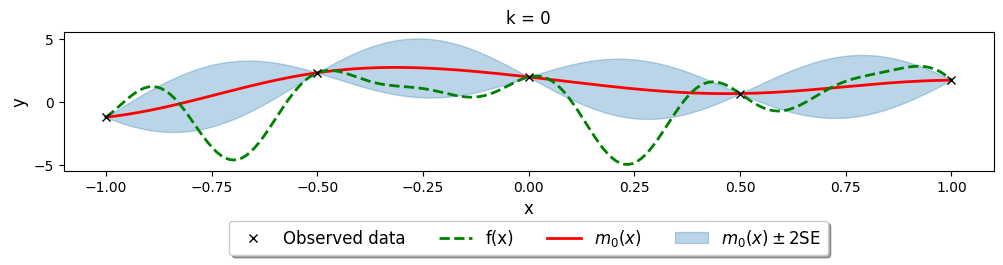

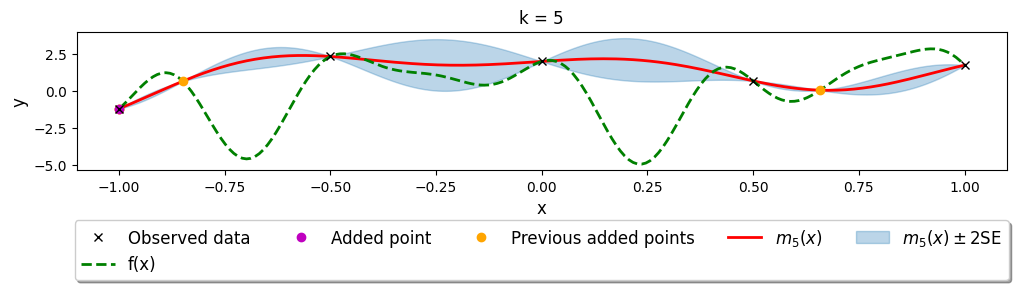

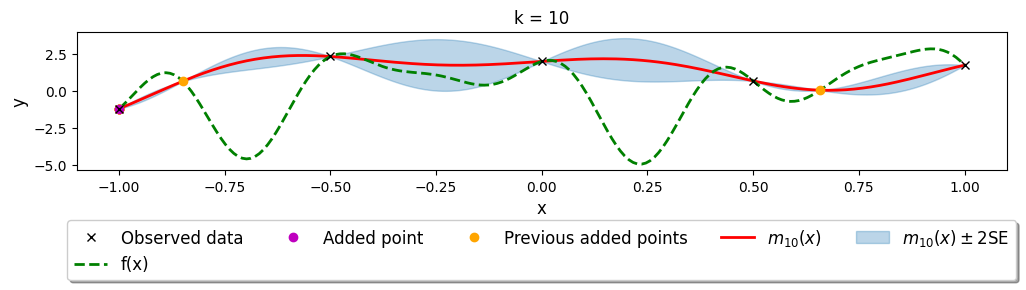

In [14]:
ks = [0, 5, 10]
for k in ks:
    fig, ax = plt.subplots(figsize=(12/1, 3))
    # D original
    ax.plot(x.numpy(), y.numpy(), "kx", label="Observed data", zorder=10)

    # f(x)
    ax.plot(X_star.numpy(), f(X_star).numpy(), "g--", lw=2, label="f(x)", zorder=4)


    # D added
    if k > 0:
        ax.plot(Dx[len(x) + k - 1].numpy(), Dy[len(x) + k -1].numpy(), "mo", label="Added point", zorder=5)
    if k > 0:
        ax.plot(Dx[len(x):len(x) + k - 1].numpy(), Dy[len(x):len(x) + k - 1].numpy(), "o", c="orange", label="Previous added points", zorder=4)

    # f_k*
    f_mean = f_stars[k][0]
    f_cov = f_stars[k][1]
    sd = f_cov.sqrt()
    # Plot mean of f*
    ax.plot(X_star.numpy(), f_mean.detach().numpy(), "r", lw=2, label=f"$m_{{{k}}}(x)$", zorder=3)
    # plot the two-sigma uncertainty about the mean
    ax.fill_between(
        X_star.numpy(),
        (f_mean - 2.0 * sd).detach().numpy(),
        (f_mean + 2.0 * sd).detach().numpy(),
        color="C0",
        alpha=0.3,
        label=f"$m_{{{k}}}(x)\pm$2SE",
        zorder=2
    )
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_title(f"k = {k}", fontsize=12)
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    percent_shrink = 0.6
    ax.set_position([box.x0, box.y0 + box.height * percent_shrink, box.width, box.height * percent_shrink])

    # Put a legend below current axis
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -percent_shrink/2), fancybox=True, shadow=True, ncol=5, prop={'size': 12})
    plt.show()

# Proposal uniform distribution

In [85]:
# Initialize
Dx, Dy = x, y # (x,y) from B.1
X_star = torch.linspace(-1, 1, 200)
gpr_3 = gpr
f_stars = []
T = 10
mcmc_3 = mcmc
minimum = None

k = 0
while k <= T:

    # Get mean and variance for each point
    f_loc, f_var = gpr_3(X_star)
    # Sample a normal with mean and variance from GPR
    y_star = torch.distributions.Normal(f_loc, f_var.sqrt()).rsample()
    f_stars.append([f_loc, f_var])
    j = torch.argmin(y_star)
    
    # If x_star[j] is already in Dx we sample j from a uniform distribution
    while X_star[j].item() in Dx:
        j = torch.randint(low=0, high=len(X_star)-1, size=(1,)).item()
        print("Was uniform distributed: ", end='')

    # j:j+1 is just for keeping the dimensions to 1
    Dx = torch.cat([Dx, X_star[j:j+1]])
    Dy = torch.cat([Dy, f(X_star[j:j+1])])

    # Save current minimum
    if minimum is None or Dy[-1].item() < minimum[1]:
        minimum = (Dx[-1].item(), Dy[-1].item())

    # Print
    print(f"{k}: Added ({Dx[-1].item()}, {Dy[-1].item()}), current minimum: {minimum}")

    # Create new GPR
    kernel_3 = gp.kernels.RBF(input_dim=1)
    kernel_3.variance = pyro.nn.PyroSample(sigma_v)
    kernel_3.lengthscale = pyro.nn.PyroSample(sigma_l)
    gpr_3 = gp.models.GPRegression(Dx, Dy, kernel_3, noise=GP_noise)

    # Sample using nuts
    nuts_kernel_3 = pyro.infer.NUTS(gpr_3.model)
    mcmc_3 = pyro.infer.MCMC(nuts_kernel_3, num_samples=N, warmup_steps=mcmc_3.warmup_steps)
    mcmc_3.run()
    k += 1

0: Added (-0.839195966720581, 0.3512427806854248), current minimum: (-0.839195966720581, 0.3512427806854248)


Sample: 100%|██████████| 700/700 [00:23, 29.58it/s, step size=2.50e-01, acc. prob=0.926]


Was uniform distributed: 1: Added (0.5276381969451904, 0.04542006924748421), current minimum: (0.5276381969451904, 0.04542006924748421)


Sample: 100%|██████████| 700/700 [00:20, 34.08it/s, step size=4.50e-01, acc. prob=0.964]


2: Added (0.7587940096855164, 1.754091501235962), current minimum: (0.5276381969451904, 0.04542006924748421)


Sample: 100%|██████████| 700/700 [00:14, 48.94it/s, step size=8.42e-01, acc. prob=0.816]


3: Added (-0.1557788848876953, 0.4368859529495239), current minimum: (0.5276381969451904, 0.04542006924748421)


Sample: 100%|██████████| 700/700 [00:14, 48.53it/s, step size=1.14e+00, acc. prob=0.839]


Was uniform distributed: 4: Added (0.44723618030548096, 1.5767240524291992), current minimum: (0.5276381969451904, 0.04542006924748421)


Sample: 100%|██████████| 700/700 [00:16, 41.50it/s, step size=6.59e-01, acc. prob=0.895]


Was uniform distributed: 5: Added (-0.7487437129020691, -3.6028637886047363), current minimum: (-0.7487437129020691, -3.6028637886047363)


Sample: 100%|██████████| 700/700 [00:18, 37.13it/s, step size=6.22e-01, acc. prob=0.942]


6: Added (-0.6783919334411621, -4.4387335777282715), current minimum: (-0.6783919334411621, -4.4387335777282715)


Sample: 100%|██████████| 700/700 [00:15, 46.27it/s, step size=9.15e-01, acc. prob=0.867]


7: Added (-0.6884421706199646, -4.558579921722412), current minimum: (-0.6884421706199646, -4.558579921722412)


Sample: 100%|██████████| 700/700 [00:17, 39.20it/s, step size=5.61e-01, acc. prob=0.929]


Was uniform distributed: 8: Added (0.0854271650314331, 0.7419055700302124), current minimum: (-0.6884421706199646, -4.558579921722412)


Sample: 100%|██████████| 700/700 [00:15, 45.82it/s, step size=7.43e-01, acc. prob=0.861]


9: Added (-0.6984924674034119, -4.5961527824401855), current minimum: (-0.6984924674034119, -4.5961527824401855)


Sample: 100%|██████████| 700/700 [00:17, 39.65it/s, step size=6.69e-01, acc. prob=0.916]


Was uniform distributed: 10: Added (-0.01507541723549366, 1.8393181562423706), current minimum: (-0.6984924674034119, -4.5961527824401855)


Sample: 100%|██████████| 700/700 [00:18, 37.16it/s, step size=6.61e-01, acc. prob=0.886]


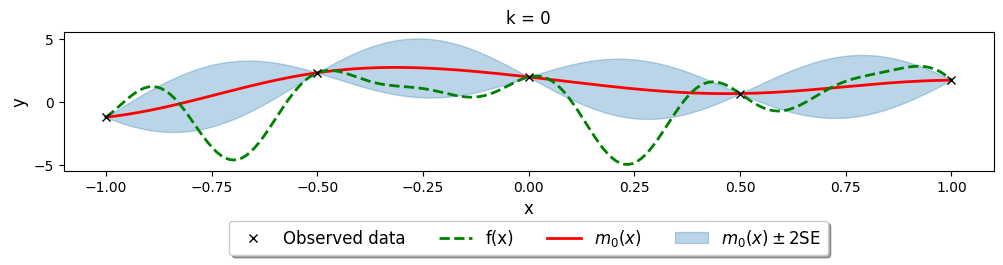

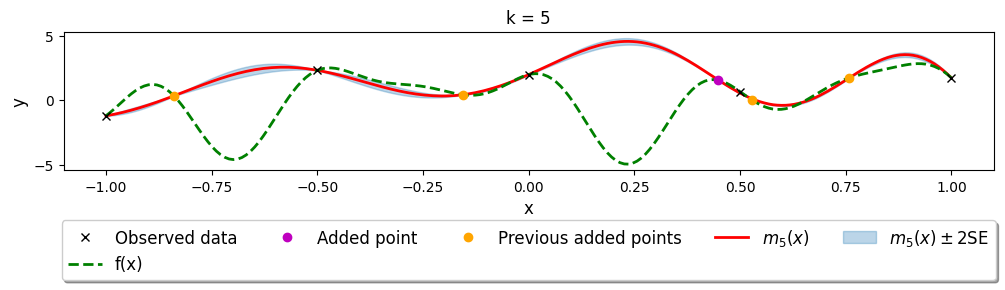

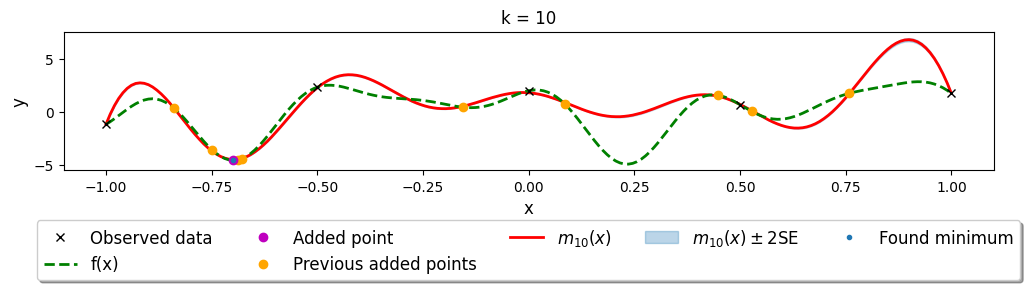

In [86]:
ks = [0, 5, 10]
for k in ks:
    fig, ax = plt.subplots(figsize=(12/1, 3))
    # D original
    ax.plot(x.numpy(), y.numpy(), "kx", label="Observed data", zorder=10)

    # f(x)
    ax.plot(X_star.numpy(), f(X_star).numpy(), "g--", lw=2, label="f(x)", zorder=4)


    # D added
    if k > 0:
        ax.plot(Dx[len(x) + k - 1].numpy(), Dy[len(x) + k -1].numpy(), "mo", label="Added point", zorder=5)
    if k > 0:
        ax.plot(Dx[len(x):len(x) + k - 1].numpy(), Dy[len(x):len(x) + k - 1].numpy(), "o", c="orange", label="Previous added points", zorder=4)

    # f_k*
    f_mean = f_stars[k][0]
    f_cov = f_stars[k][1]
    sd = f_cov.sqrt()
    # Plot mean of f*
    ax.plot(X_star.numpy(), f_mean.detach().numpy(), "r", lw=2, label=f"$m_{{{k}}}(x)$", zorder=3)
    # plot the two-sigma uncertainty about the mean
    ax.fill_between(
        X_star.numpy(),
        (f_mean - 2.0 * sd).detach().numpy(),
        (f_mean + 2.0 * sd).detach().numpy(),
        color="C0",
        alpha=0.3,
        label=f"$m_{{{k}}}(x)\pm$2SE",
        zorder=2
    )
    if k == ks[-1]:
        ax.plot(minimum[0], minimum[1], ".", label="Found minimum", zorder=5)

    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_title(f"k = {k}", fontsize=12)
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    percent_shrink = 0.6
    ax.set_position([box.x0, box.y0 + box.height * percent_shrink, box.width, box.height * percent_shrink])

    # Put a legend below current axis
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -percent_shrink/2), fancybox=True, shadow=True, ncol=5, prop={'size': 12})
    plt.show()